In [1]:
import pandas as pd
import model.processing_utils as pu
import numpy as np

In [2]:

def parse_categories(filename):
    categories = {}
    current_path = []
    
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    for line in lines:
        if not line.strip() or 'Category ID' in line:
            continue
            
        parts = line.strip().split('\t')
        if len(parts) != 3:
            continue
            
        id, name, path = parts
        levels = path.split(' > ')
        
        # Reset or build current path based on levels
        if len(levels) == 1:
            current_path = []
        current_path = current_path[:len(levels)-1]
        current_path.append(name)
        
        # Build nested dictionary structure
        current_dict = categories
        for i, level in enumerate(levels[:-1]):
            if level not in current_dict:
                current_dict[level] = {"id": "", "subcategories": {}}
            current_dict = current_dict[level]["subcategories"]
            
        # Add the final category
        if levels[-1] not in current_dict:
            current_dict[levels[-1]] = {"id": id}
            if len(current_path) < len(levels):
                current_dict[levels[-1]]["subcategories"] = {}
    
    return categories


In [3]:
import json
file_path = 'data/raw/tax.txt'
category_dict = {}

# Open the file and process it
with open(file_path, "r") as file:
    # Skip the header line
    header = next(file)
    
    for line in file:
        # Split the line into components
        components = line.strip().split("\t")
        
        # Ensure the line has exactly 3 columns
        if len(components) == 3:
            category_id, category_name, category_label = components
            # Split the Category Label into hierarchy levels
            hierarchy = category_label.split(" > ")
            # Add to the dictionary
            category_dict[category_id] = hierarchy



In [4]:
category_dict

{'Category ID': ['Category Label'],
 '4d4b7104d754a06370d81259': ['Arts and Entertainment'],
 '4bf58dd8d48988d182941735': ['Arts and Entertainment', 'Amusement Park'],
 '5109983191d435c0d71c2bb1': ['Arts and Entertainment',
  'Amusement Park',
  'Attraction'],
 '4fceea171983d5d06c3e9823': ['Arts and Entertainment', 'Aquarium'],
 '4bf58dd8d48988d1e1931735': ['Arts and Entertainment', 'Arcade'],
 '4bf58dd8d48988d1e2931735': ['Arts and Entertainment', 'Art Gallery'],
 '63be6904847c3692a84b9b20': ['Arts and Entertainment', 'Bingo Center'],
 '4bf58dd8d48988d1e4931735': ['Arts and Entertainment', 'Bowling Alley'],
 '63be6904847c3692a84b9b21': ['Arts and Entertainment', 'Carnival'],
 '4bf58dd8d48988d17c941735': ['Arts and Entertainment', 'Casino'],
 '52e81612bcbc57f1066b79e7': ['Arts and Entertainment', 'Circus'],
 '4bf58dd8d48988d18e941735': ['Arts and Entertainment', 'Comedy Club'],
 '63be6904847c3692a84b9b22': ['Arts and Entertainment', 'Country Club'],
 '52e81612bcbc57f1066b79ef': ['Arts 

In [5]:
df_cp = pd.read_csv("data/raw/foursquare_complete_ny.csv")

df_cp.dropna(subset=["venue_category_ID", "timezone"], inplace=True)
#rename lon to lng and venue_id to venueID
df_cp.rename(columns={"lon": "lng", "venue_id": "venueID", 'utc_time':'time', 'venue_category_name':'venue_descr'}, inplace=True)
#reorder columns
df_cp = df_cp[['uid',  'lat', 'lng', 'venueID', 'venue_descr', 'time', 'venue_category_id']]

df_cp["venueID"] = df_cp["venueID"].astype(str)

df_cp["time"] = pd.to_datetime(df_cp["time"])
df_cp["city_name"] = "New York City"

df_cp.head()

/tmp/ipykernel_3523403/3179263658.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cp["time"] = pd.to_datetime(df_cp["time"])


,uid,lat,lng,venueID,venue_descr,time,venue_category_id,city_name
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,4bf58dd8d48988d1c1941735,New York City
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,4bf58dd8d48988d147941735,New York City
2,1,40.645089,-73.784523,1511,Airport,2012-08-10 16:40:07+00:00,4bf58dd8d48988d1ed931735,New York City
3,1,40.640856,-73.789201,6720,Steakhouse,2012-08-10 17:05:07+00:00,4bf58dd8d48988d1cc941735,New York City
4,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,4bf58dd8d48988d1ce941735,New York City


In [6]:
#sample 5 rows
df_s = df_cp.sample(5)
#sort by date
df_s = df_s.sort_values(by="time")
df_s

,uid,lat,lng,venueID,venue_descr,time,venue_category_id,city_name
51815,261,40.703585,-73.799299,22887,Bus Station,2012-04-18 13:11:57+00:00,4bf58dd8d48988d12b951735,New York City
63891,312,40.749085,-73.982257,5772,Gym / Fitness Center,2012-05-09 01:11:40+00:00,4bf58dd8d48988d176941735,New York City
79422,371,40.779754,-73.793723,21990,Cosmetics Shop,2012-05-12 18:09:36+00:00,4bf58dd8d48988d10c951735,New York City
45270,219,40.719528,-73.947391,33324,Athletic & Sport,2012-07-17 06:09:12+00:00,4e39a956bd410d7aed40cbc3,New York City
117312,536,40.763966,-73.915114,3873,Gym / Fitness Center,2012-12-06 01:11:25+00:00,4bf58dd8d48988d176941735,New York City


In [7]:
df_cp["First_Category"] = df_cp["venue_category_id"].apply(lambda x: category_dict[x][0] if x in category_dict else "Unknown")

df_cp["Second_Category"] = df_cp["venue_category_id"].apply(
    lambda x: category_dict[x][1] if x in category_dict and len(category_dict[x]) > 1 else "Unknown"
)
df_cp["Second_Category"] = df_cp.apply(
    lambda row: row["First_Category"] if row["Second_Category"] == "Unknown" else row["Second_Category"], axis=1
)


df_cp["Third_Category"] = df_cp["venue_category_id"].apply(
    lambda x: category_dict[x][2] if x in category_dict and len(category_dict[x]) > 2 else "Unknown"
)
df_cp["Third_Category"] = df_cp.apply(
    lambda row: row["Second_Category"] if row["Third_Category"] == "Unknown" else row["Third_Category"], axis=1
)


In [8]:
df_cp

,uid,lat,lng,venueID,venue_descr,time,venue_category_id,city_name,First_Category,Second_Category,Third_Category
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,4bf58dd8d48988d1c1941735,New York City,Dining and Drinking,Restaurant,Mexican Restaurant
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,4bf58dd8d48988d147941735,New York City,Dining and Drinking,Restaurant,Diner
2,1,40.645089,-73.784523,1511,Airport,2012-08-10 16:40:07+00:00,4bf58dd8d48988d1ed931735,New York City,Travel and Transportation,Transport Hub,Airport
3,1,40.640856,-73.789201,6720,Steakhouse,2012-08-10 17:05:07+00:00,4bf58dd8d48988d1cc941735,New York City,Dining and Drinking,Restaurant,Steakhouse
4,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,4bf58dd8d48988d1ce941735,New York City,Dining and Drinking,Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
227423,1083,40.750795,-73.993576,1313,Train Station,2012-11-21 20:36:17+00:00,4bf58dd8d48988d129951735,New York City,Travel and Transportation,Transport Hub,Rail Station
227424,1083,40.746119,-73.993070,31835,Gym / Fitness Center,2012-10-24 11:18:02+00:00,4bf58dd8d48988d176941735,New York City,Sports and Recreation,Gym and Studio,Gym
227425,1083,40.745518,-73.992351,4127,Office,2012-09-05 18:08:42+00:00,4bf58dd8d48988d124941735,New York City,Business and Professional Services,Office,Office
227426,1083,40.750795,-73.993576,1313,Train Station,2012-09-05 21:17:39+00:00,4bf58dd8d48988d129951735,New York City,Travel and Transportation,Transport Hub,Rail Station


In [9]:
#drop lines with unknwown in either first or second category
df_cp = df_cp[(df_cp["First_Category"] != "Unknown") & (df_cp["Second_Category"] != "Unknown")]
df_cp.drop(columns=["venue_category_id"], inplace=True)
df_cp

/tmp/ipykernel_3523403/3185552217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cp.drop(columns=["venue_category_id"], inplace=True)


,uid,lat,lng,venueID,venue_descr,time,city_name,First_Category,Second_Category,Third_Category
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,New York City,Dining and Drinking,Restaurant,Mexican Restaurant
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,New York City,Dining and Drinking,Restaurant,Diner
2,1,40.645089,-73.784523,1511,Airport,2012-08-10 16:40:07+00:00,New York City,Travel and Transportation,Transport Hub,Airport
3,1,40.640856,-73.789201,6720,Steakhouse,2012-08-10 17:05:07+00:00,New York City,Dining and Drinking,Restaurant,Steakhouse
4,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,New York City,Dining and Drinking,Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...
227423,1083,40.750795,-73.993576,1313,Train Station,2012-11-21 20:36:17+00:00,New York City,Travel and Transportation,Transport Hub,Rail Station
227424,1083,40.746119,-73.993070,31835,Gym / Fitness Center,2012-10-24 11:18:02+00:00,New York City,Sports and Recreation,Gym and Studio,Gym
227425,1083,40.745518,-73.992351,4127,Office,2012-09-05 18:08:42+00:00,New York City,Business and Professional Services,Office,Office
227426,1083,40.750795,-73.993576,1313,Train Station,2012-09-05 21:17:39+00:00,New York City,Travel and Transportation,Transport Hub,Rail Station


In [10]:
sorted(df_cp["Third_Category"].unique())

['Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'American Restaurant',
 'Amusement Park',
 'Animal Shelter',
 'Antique Store',
 'Apartment or Condo',
 'Apres Ski Bar',
 'Aquarium',
 'Arcade',
 'Art Gallery',
 'Art Museum',
 'Arts and Crafts Store',
 'Arts and Entertainment',
 'Asian Restaurant',
 'Assisted Living',
 'Auditorium',
 'Australian Restaurant',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Banking and Finance',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed and Breakfast',
 'Beer Garden',
 'Bicycle Store',
 'Bike Rental',
 'Board Store',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bridal Store',
 'Bridge',
 'Burger Joint',
 'Bus Station',
 'Business and Professional Services',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cajun and Creole Restaurant',
 'Camera Store',
 'Campground',
 'Candy Store',
 'Capitol Building',
 'Car Dealership',
 'Car Was

In [11]:
#from df_cp drop lines that have as Third_Category  Meeting Room, Conference Room, Office, Home (private) Apartment or Condo
df_cp = df_cp[~df_cp["Third_Category"].isin(["Meeting Room", "Conference Room", "Office", "Home (private)", "Apartment or Condo"])]
df_cp

,uid,lat,lng,venueID,venue_descr,time,city_name,First_Category,Second_Category,Third_Category
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,New York City,Dining and Drinking,Restaurant,Mexican Restaurant
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,New York City,Dining and Drinking,Restaurant,Diner
2,1,40.645089,-73.784523,1511,Airport,2012-08-10 16:40:07+00:00,New York City,Travel and Transportation,Transport Hub,Airport
3,1,40.640856,-73.789201,6720,Steakhouse,2012-08-10 17:05:07+00:00,New York City,Dining and Drinking,Restaurant,Steakhouse
4,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,New York City,Dining and Drinking,Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...
227422,1083,40.734641,-73.979287,19121,Bus Station,2012-11-21 13:18:55+00:00,New York City,Travel and Transportation,Transport Hub,Bus Station
227423,1083,40.750795,-73.993576,1313,Train Station,2012-11-21 20:36:17+00:00,New York City,Travel and Transportation,Transport Hub,Rail Station
227424,1083,40.746119,-73.993070,31835,Gym / Fitness Center,2012-10-24 11:18:02+00:00,New York City,Sports and Recreation,Gym and Studio,Gym
227426,1083,40.750795,-73.993576,1313,Train Station,2012-09-05 21:17:39+00:00,New York City,Travel and Transportation,Transport Hub,Rail Station


In [12]:
sorted(list(df_cp["Second_Category"].unique()))

['Amusement Park',
 'Animal Shelter',
 'Antique Store',
 'Aquarium',
 'Arcade',
 'Art Gallery',
 'Arts and Crafts Store',
 'Arts and Entertainment',
 'Assisted Living',
 'Auditorium',
 'Automotive Retail',
 'Automotive Service',
 'Automotive Shop',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Baseball',
 'Basketball',
 'Beach',
 'Bike Rental',
 'Board Store',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bridge',
 'Business and Professional Services',
 'Cafe, Coffee, and Tea House',
 'Cafeteria',
 'Campground',
 'Casino',
 'Castle',
 'Cemetery',
 'Child Care Service',
 'Comedy Club',
 'Computers and Electronics Retail',
 'Convenience Store',
 'Convention Center',
 'Cosmetics Store',
 'Dentist',
 'Department Store',
 'Design Studio',
 'Dessert Shop',
 'Distillery',
 'Donut Shop',
 'Education',
 'Emergency Service',
 'Event Space',
 'Eyecare Store',
 'Factory',
 'Fair',
 'Farm',
 'Fashion Retail',
 'Field',
 'Financial Service',
 'Financial or Leg

In [13]:
#from df_cp drop lines whose Second Category is transportation or strange things
df_cp = df_cp[~df_cp["Second_Category"].isin(["Train", "Transport Hub", "Transportation Service", "Travel and Transportation", 
                                              "Boat or Ferry", "Platform", "Road",
                                              "Island", "River", "Housing Development"
                                              ])]


In [14]:
df_cp["time"].min(), df_cp["time"].max()

(Timestamp('2012-04-03 18:00:09+0000', tz='UTC'),
 Timestamp('2013-02-16 02:35:36+0000', tz='UTC'))

In [15]:
df_cp_venues = df_cp[["venueID", "lat", "lng", "First_Category", "Second_Category", "Third_Category"]].drop_duplicates()

df_cp_venues

,venueID,lat,lng,First_Category,Second_Category,Third_Category
0,33236,40.717888,-74.005668,Dining and Drinking,Restaurant,Mexican Restaurant
1,791,40.733763,-74.006264,Dining and Drinking,Restaurant,Diner
3,6720,40.640856,-73.789201,Dining and Drinking,Restaurant,Steakhouse
4,255,40.734895,-74.003155,Dining and Drinking,Restaurant,Seafood Restaurant
5,5321,40.733022,-74.004033,Retail,Record Store,Record Store
...,...,...,...,...,...,...
227289,7535,40.745926,-73.990662,Business and Professional Services,Financial Service,Banking and Finance
227302,13518,40.740693,-73.997097,Retail,Boutique,Boutique
227305,14,40.724612,-73.990485,Dining and Drinking,Bar,Gay Bar
227339,15284,40.745702,-73.993653,Dining and Drinking,Restaurant,Burger Joint


In [16]:
from collections import defaultdict


venueID2second_category = defaultdict(list)

for index, row in df_cp.iterrows():
    venueID2second_category[row["venueID"]].append(row["Second_Category"])


venueID2second_category = {k: list(set(v)) for k, v in venueID2second_category.items()}
venueID2second_category

{'33236': ['Restaurant'],
 '791': ['Restaurant'],
 '6720': ['Restaurant'],
 '255': ['Restaurant'],
 '5321': ['Record Store'],
 '7469': ['Health and Beauty Service'],
 '1328': ['Bar'],
 '5041': ['Restaurant'],
 '4924': ['Restaurant'],
 '35766': ['Structure'],
 '962': ['Restaurant', 'Breakfast Spot'],
 '1928': ['Restaurant'],
 '7264': ['Park'],
 '2642': ['Cafe, Coffee, and Tea House'],
 '5848': ['Restaurant'],
 '24553': ['Restaurant'],
 '2149': ['Bar'],
 '23850': ['Restaurant'],
 '982': ['Bar'],
 '2521': ['Restaurant'],
 '1308': ['Lodging'],
 '12420': ['Bar'],
 '7948': ['Restaurant'],
 '30003': ['Bar'],
 '841': ['Restaurant'],
 '2075': ['Restaurant'],
 '29743': ['Restaurant'],
 '816': ['Record Store'],
 '2757': ['Bar'],
 '4195': ['Computers and Electronics Retail'],
 '6266': ['Music Store'],
 '21082': ['Restaurant'],
 '6427': ['Restaurant'],
 '690': ['Bar'],
 '680': ['Restaurant'],
 '1793': ['Museum'],
 '3193': ['Bar'],
 '183': ['Bar'],
 '2166': ['Performing Arts Venue'],
 '22855': ['Res

In [17]:
#retrieve venueIDs with more than one category
venueID2second_category = {k: v for k, v in venueID2second_category.items() if len(v) > 1}
len(venueID2second_category)

178

In [18]:
to_drop = venueID2second_category.keys()

df_cp_removed = df_cp[~df_cp["venueID"].isin(to_drop)]

In [19]:
to_drop_values = [item for sublist in venueID2second_category.values() for item in sublist]
to_drop_values = sorted(list(set(to_drop_values)))
to_drop_values

['Animal Shelter',
 'Assisted Living',
 'Bar',
 'Beach',
 'Bookstore',
 'Breakfast Spot',
 'Bridge',
 'Cafe, Coffee, and Tea House',
 'Castle',
 'Computers and Electronics Retail',
 'Convenience Store',
 'Convention Center',
 'Cosmetics Store',
 'Dentist',
 'Department Store',
 'Design Studio',
 'Dessert Shop',
 'Donut Shop',
 'Education',
 'Event Space',
 'Factory',
 'Fashion Retail',
 'Financial or Legal Service',
 'Food Court',
 'Food and Beverage Retail',
 'Furniture and Home Store',
 'General Travel',
 'Gift Store',
 'Government Building',
 'Gym and Studio',
 'Harbor or Marina',
 'Hiking Trail',
 'Hobby Store',
 'Juice Bar',
 'Market',
 'Medical Center',
 'Miscellaneous Store',
 'Moving Target',
 'Museum',
 'Newsstand',
 'Night Club',
 'Office',
 'Office Supply Store',
 'Organization',
 'Other Great Outdoors',
 'Other Nightlife',
 'Park',
 'Performing Arts Venue',
 'Pet Service',
 'Pharmacy',
 'Physician',
 'Pier',
 'Plaza',
 'Public Art',
 'Restaurant',
 'Scenic Lookout',
 'Sculp

In [20]:
(len(df_cp) - len(df_cp_removed)) / len(df_cp)

0.020438695693148618

In [21]:
#drop third category
df_cp_removed.drop(columns=["Third_Category"], inplace=True)

/tmp/ipykernel_3523403/2630295318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cp_removed.drop(columns=["Third_Category"], inplace=True)


In [22]:
df_cp = df_cp_removed

In [23]:
len(df_cp)

166306

In [24]:
df_cp

,uid,lat,lng,venueID,venue_descr,time,city_name,First_Category,Second_Category
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,New York City,Dining and Drinking,Restaurant
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,New York City,Dining and Drinking,Restaurant
3,1,40.640856,-73.789201,6720,Steakhouse,2012-08-10 17:05:07+00:00,New York City,Dining and Drinking,Restaurant
4,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,New York City,Dining and Drinking,Restaurant
5,1,40.733022,-74.004033,5321,Record Shop,2012-12-14 18:49:03+00:00,New York City,Retail,Record Store
...,...,...,...,...,...,...,...,...,...
227417,1083,40.732119,-73.985412,619,Bar,2012-05-16 04:22:00+00:00,New York City,Dining and Drinking,Bar
227418,1083,40.745270,-73.992309,6628,Hotel,2012-05-16 22:43:23+00:00,New York City,Travel and Transportation,Lodging
227419,1083,40.746445,-73.993921,4665,Deli / Bodega,2012-05-23 17:06:53+00:00,New York City,Dining and Drinking,Restaurant
227420,1083,40.744529,-73.991746,32129,Clothing Store,2012-05-30 00:14:33+00:00,New York City,Retail,Fashion Retail


In [ ]:
import os
if not os.path.exists("data/processed/foursquare_complete_nyc_cp_full.csv"):
    df_cp = pd.read_csv("data/processed/foursquare_complete_nyc_cp_full.csv")


In [ ]:
#save a random sample of the data
df_cp_small = df_cp.iloc[:50000]
df_cp_medium = df_cp.iloc[:100000]

df_cp_small.to_csv("data/processed/foursquare_complete_nyc_cp_small.csv", index=False)
df_cp_medium.to_csv("data/processed/foursquare_complete_nyc_cp_medium.csv", index=False)

In [27]:
df_train = pd.read_csv("data/processed/training_data_city_nyc-full__trainWindow_100__.csv", index_col=0)
df_train.head()

,uid,lat,lng,venueID,venue_descr,time,city_name,First_Category,Second_Category
0,1,40.717888,-74.005668,33236,Mexican Restaurant,2012-04-13 15:41:41+00:00,New York City,Dining and Drinking,Restaurant
1,1,40.733763,-74.006264,791,Diner,2012-04-20 01:49:26+00:00,New York City,Dining and Drinking,Restaurant
5,1,40.722735,-74.010443,7469,Salon / Barbershop,2012-07-06 20:48:44+00:00,New York City,Business and Professional Services,Health and Beauty Service
7,1,40.767688,-73.985037,5041,American Restaurant,2012-06-08 23:55:38+00:00,New York City,Dining and Drinking,Restaurant
8,1,40.719690,-74.008543,4924,Sandwich Place,2012-05-11 16:10:55+00:00,New York City,Dining and Drinking,Restaurant


In [28]:
lat_lon_tuples = set()
lat_lon = df_train[['lat', 'lng']].values
for i in range(len(lat_lon)):
    lat_lon_tuples.add(tuple(lat_lon[i]))
len(lat_lon_tuples)

25656

In [ ]:
df_cp["time"].min(), df_cp["time"].max()

(Timestamp('2012-04-03 18:00:09+0000', tz='UTC'),
 Timestamp('2013-02-16 02:35:36+0000', tz='UTC'))

In [ ]:
df_cp.dtypes

uid                              int64
lat                            float64
lng                            float64
venueID                         object
venue_descr                     object
time               datetime64[ns, UTC]
city_name                       object
First_Category                  object
Second_Category                 object
Third_Category                  object
dtype: object

In [ ]:
df_cp["First_Category"].value_counts(normalize=True)

First_Category
Dining and Drinking                   0.295634
Travel and Transportation             0.151408
Community and Government              0.142669
Retail                                0.106689
Landmarks and Outdoors                0.105541
Business and Professional Services    0.085516
Arts and Entertainment                0.051312
Sports and Recreation                 0.045318
Health and Medicine                   0.014650
Nightlife Spot                        0.001262
Name: proportion, dtype: float64

In [ ]:
distance_list = []

# Process each user's visits
for uid, user_visits in df_cp.groupby('uid'):
    visited_venues = set()   # to keep track of venues already visited
    last_lat, last_lng = None, None  # coordinates of the last new (not repeated) POI
    
    # It's important that the visits are in chronological order.
    # Here we assume that the DataFrame's order represents the visit order.
    for idx, row in user_visits.iterrows():
        venue = row['venueID']
        
        # Check if the venue is being visited for the first time
        if venue not in visited_venues:
            # If this is not the first new venue, calculate the distance from the last one
            if last_lat is not None and last_lng is not None:
                d = pu.haversine(last_lat, last_lng, row['lat'], row['lng'])
                distance_list.append(d)
            
            # Mark the venue as visited and update last visited coordinates
            visited_venues.add(venue)
            last_lat, last_lng = row['lat'], row['lng']
        else:
            last_lat, last_lng = row['lat'], row['lng']
            # If the venue was already visited, we skip calculating the distance
            continue


In [ ]:
np.mean(distance_list), np.std(distance_list), np.median(distance_list), np.percentile(distance_list, 75)

(4881.81089856955, 5976.411262130449, 2491.6788900026477, 6674.595521335565)

(array([1.7532e+04, 8.5990e+03, 5.9590e+03, 4.8210e+03, 4.0660e+03,
        3.4310e+03, 3.1230e+03, 2.9140e+03, 2.6530e+03, 2.4210e+03,
        2.2880e+03, 1.9990e+03, 1.7540e+03, 1.6510e+03, 1.4880e+03,
        1.3000e+03, 1.1350e+03, 1.0070e+03, 9.7700e+02, 9.6900e+02,
        8.4500e+02, 8.8700e+02, 6.9500e+02, 6.7500e+02, 6.7600e+02,
        6.5200e+02, 6.3300e+02, 5.7000e+02, 6.0900e+02, 5.3300e+02,
        5.5300e+02, 4.9100e+02, 5.0400e+02, 5.0500e+02, 4.6900e+02,
        4.9400e+02, 4.2600e+02, 4.6500e+02, 4.2600e+02, 3.8100e+02,
        3.4600e+02, 3.0700e+02, 3.5300e+02, 3.2300e+02, 3.1300e+02,
        3.7200e+02, 2.7800e+02, 3.2200e+02, 2.8000e+02, 2.1900e+02,
        1.7100e+02, 1.7000e+02, 1.5700e+02, 1.3800e+02, 1.2700e+02,
        1.0400e+02, 8.9000e+01, 6.7000e+01, 5.6000e+01, 5.5000e+01,
        6.7000e+01, 5.5000e+01, 4.8000e+01, 2.9000e+01, 3.4000e+01,
        3.0000e+01, 2.9000e+01, 3.3000e+01, 2.4000e+01, 1.9000e+01,
        1.6000e+01, 7.0000e+00, 9.0000e+00, 9.00

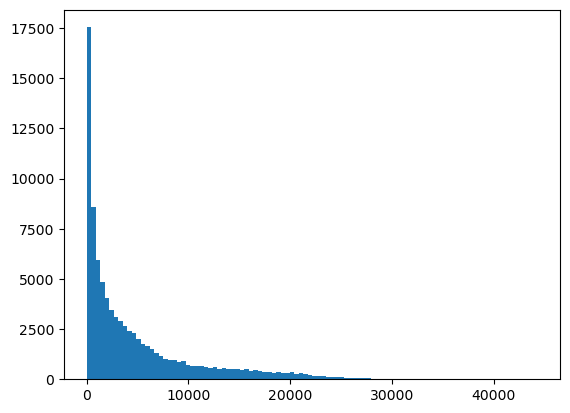

In [ ]:
#plot distance_list
import matplotlib.pyplot as plt

plt.hist(distance_list, bins=100)
#log scale


(array([0.20296835, 0.30251916, 0.37150663, 0.42731946, 0.47439163,
        0.51411239, 0.55026743, 0.58400287, 0.61471671, 0.64274468,
        0.66923291, 0.69237537, 0.71268147, 0.73179513, 0.74902174,
        0.76407187, 0.77721179, 0.78886985, 0.8001806 , 0.81139874,
        0.82118132, 0.83145014, 0.83949617, 0.84731066, 0.85513672,
        0.86268494, 0.8700132 , 0.8766121 , 0.88366251, 0.88983306,
        0.89623515, 0.90191947, 0.90775429, 0.91360069, 0.91903031,
        0.92474936, 0.92968117, 0.93506448, 0.9399963 , 0.94440714,
        0.94841279, 0.95196694, 0.95605362, 0.959793  , 0.96341661,
        0.96772326, 0.97094167, 0.97466948, 0.97791104, 0.98044641,
        0.98242608, 0.98439417, 0.98621177, 0.9878094 , 0.98927968,
        0.99048369, 0.99151404, 0.9922897 , 0.99293802, 0.99357475,
        0.99435041, 0.99498715, 0.99554285, 0.99587858, 0.9962722 ,
        0.99661951, 0.99695524, 0.99733728, 0.99761513, 0.9978351 ,
        0.99802033, 0.99810137, 0.99820556, 0.99

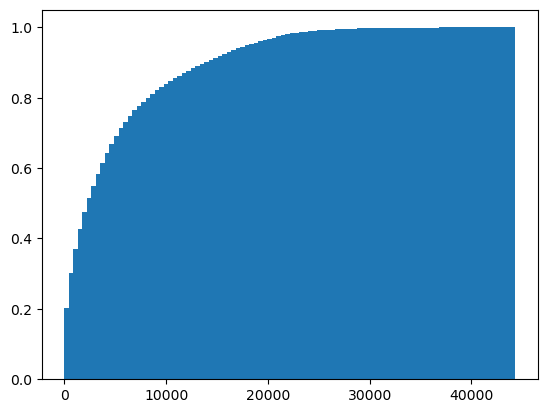

In [ ]:
#cumulative distribution
plt.hist(distance_list, bins=100, cumulative=True, density=True)

In [ ]:
#75th percentile
np.percentile(distance_list, 75)

6674.595521335565

In [ ]:
#plot map of the venues

import folium

df_cp_venues = df_cp_small.drop_duplicates(subset="venueID")

# Create a map centered at the mean latitude and longitude
map = folium.Map(location=[df_cp_venues['lat'].mean(), df_cp_venues['lng'].mean()], zoom_start=12)



# Add a marker for each venue
for idx, row in df_cp_venues.iterrows():
    folium.Marker([row['lat'], row['lng']], popup=row['venueID']).add_to(map)

map.save("data/processed/venues_map.html")


# TRAINING PROPERTIES

In [1]:
import pandas as pd
df_train = pd.read_csv("data/processed/training_data_city_nyc-full__trainWindow_210__.csv", index_col=0)
unique_poi = df_train["venueID"].nunique()
unique_users = df_train["uid"].nunique()
unique_poi, unique_users

(27413, 1063)

In [3]:
import pandas as pd

df_train_small = pd.read_csv("data/processed/training_data_city_nyc-small__trainWindow_210__.csv", index_col=0)
unique_poi_small = df_train_small["venueID"].nunique()
unique_users_small = df_train_small["uid"].nunique()
unique_poi_small, unique_users_small

(11702, 313)